[https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching)

# Setup

In [105]:
dependencies = [
    "kagtool",
    "pandas",
    "matplotlib",
    "scikit-learn",
    "kaggle",
    "fastai",
    "transformers",
    "datasets",
    "evaluate",
    "accelerate",
    "sentencepiece",
    "protobuf"
]

!pip install -U {" ".join(dependencies)}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [1]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
import warnings, logging
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

model_nm = 'microsoft/deberta-v3-large'
model = AutoModelForSequenceClassification.from_pretrained(model_nm, return_dict=True)
tokenizer = AutoTokenizer.from_pretrained(model_nm)

save_path = 'deberta_v3_large_pretrained_model_pytorch'
!mkdir {save_path}

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

!zip -r debertav3_large.zip {save_path}
# removing redundant files
!rm -rf {save_path}

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

  adding: deberta_v3_large_pretrained_model_pytorch/ (stored 0%)
  adding: deberta_v3_large_pretrained_model_pytorch/model.safetensors (deflated 41%)
  adding: deberta_v3_large_pretrained_model_pytorch/added_tokens.json (stored 0%)
  adding: deberta_v3_large_pretrained_model_pytorch/tokenizer_config.json (deflated 73%)
  adding: deberta_v3_large_pretrained_model_pytorch/special_tokens_map.json (deflated 50%)
  adding: deberta_v3_large_pretrained_model_pytorch/config.json (deflated 53%)
  adding: deberta_v3_large_pretrained_model_pytorch/tokenizer.json (deflated 77%)
  adding: deberta_v3_large_pretrained_model_pytorch/spm.model (deflated 50%)


In [106]:
from kagtool.datasets.kaggle_downloader import KaggleDownloader

dataset_name = 'us-patent-phrase-to-phrase-matching'
# add your username and key here
creds = '{"username":"","key":""}'
dataset_path = KaggleDownloader(dataset_name, creds).load_or_fetch_kaggle_dataset()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached kagtool-12.0.2-py3-none-any.whl.metadata (53 bytes)
Using cached kagtool-12.0.2-py3-none-any.whl (2.4 kB)
  Attempting uninstall: kagtool
    Found existing installation: kagtool 12.0.2
    Uninstalling kagtool-12.0.2:
      Successfully uninstalled kagtool-12.0.2

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
us-patent-phrase-to-phrase-matching.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
model_dir = '/kaggle/working/model'
model_nm = 'microsoft/deberta-v3-small'
num_labels = 1

In [107]:
from fastai.imports import *

# EDA

In [108]:
eval_df = pd.read_csv(dataset_path/'test.csv')
len(eval_df)

36

In [109]:
eval_df.head()

,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


In [110]:
df = pd.read_csv(dataset_path/'train.csv')
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


In [111]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


### Let's take a look at the TARGET COLUMN

In [112]:
df.target.describe()

count           36473
unique          29340
top       composition
freq               24
Name: target, dtype: object

In [113]:
df.target.value_counts()

target
composition                    24
data                           22
metal                          22
motor                          22
assembly                       21
                               ..
switching switch over valve     1
switching switch off valve      1
switching over valve            1
switching off valve             1
wooden substrate                1
Name: count, Length: 29340, dtype: int64

`Some Helpers`

In [114]:
import pandas as pd
import matplotlib.pyplot as plt

def unique_and_dups(col):
    uniqs = col.nunique() / len(col) * 100,
    dups = (col.duplicated().sum() / len(df)) * 100
    print(uniqs, dups)

def plot_text_length(df, col):
    df['text_length'] = df[col].apply(len)
    length_counts = df['text_length'].value_counts().sort_index(ascending=True)

    length_counts.plot(kind='bar', figsize=(10, 6))
    plt.xlabel('Text Length')
    plt.ylabel('Count')
    plt.title('Breakdown of Text Lengths')
    plt.show()

def display_text_examples_by_length(df, col):
    # Step 1: Find the minimum, maximum, and medium length of the text
    min_length = df[col].str.len().min()
    max_length = df[col].str.len().max()
    medium_length = df[col].str.len().median()

    # Step 2: Filter the DataFrame to include only the rows with the desired lengths
    min_length_rows = df[df[col].str.len() == min_length]
    max_length_rows = df[df[col].str.len() == max_length]
    medium_length_rows = df[df[col].str.len() == medium_length]

    # Step 3: Display the filtered DataFrame
    print("Examples of minimum length text:", min_length)
    print(min_length_rows[col].tolist()[:5])
    print("\nExamples of maximum length text:", max_length)
    print(max_length_rows[col].tolist()[:5])
    print("\nExamples of medium length text:", medium_length)
    print(medium_length_rows[col].tolist()[:5])

In [115]:
unique_and_dups(df.target)

(80.44306747457023,) 19.556932525429772


__What do we see?__

Lots of target, 80% unique values, feels like the independant variable X?

__Let's look at the values__

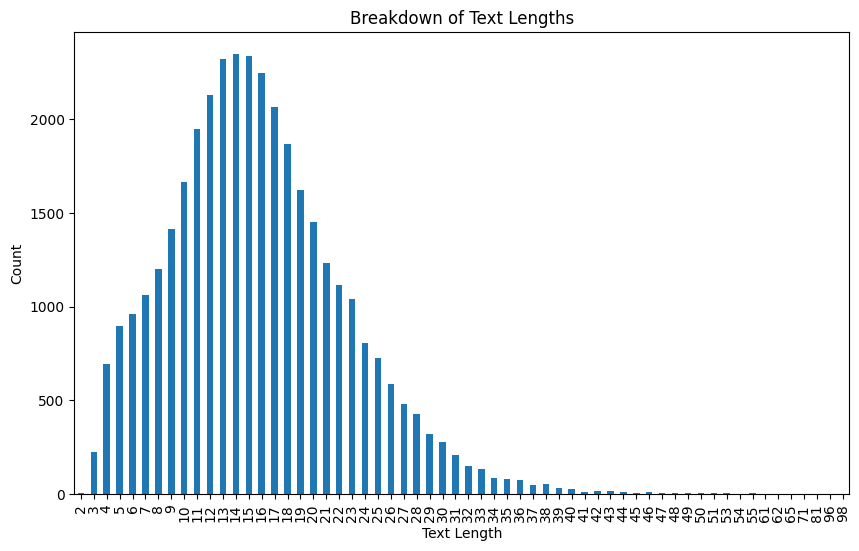

In [116]:
plot_text_length(df, 'target')

In [117]:
display_text_examples_by_length(df, 'target')

Examples of minimum length text: 2
['id', 'tv', 'tv', 'h6', 'h6']

Examples of maximum length text: 98
['2s 6 5 3as4s6ar 2 oxo 133a466a hexahydrothieno34 dimidazol 4 ylpentanoylamino 2 azaniumylhexanoate']

Examples of medium length text: 15.0
['active catalyst', 'noise reduction', 'stone abutments', 'processing unit', 'noise abatement']


### Let's take a look at the ANCHOR COLUMN

In [118]:
df.anchor.describe()

count                           36473
unique                            733
top       component composite coating
freq                              152
Name: anchor, dtype: object

In [119]:
df.anchor.value_counts()

anchor
component composite coating              152
sheet supply roller                      150
source voltage                           140
perfluoroalkyl group                     136
el display                               135
                                        ... 
plug nozzle                                2
shannon                                    2
dry coating composition1                   2
peripheral nervous system stimulation      1
conduct conducting material                1
Name: count, Length: 733, dtype: int64

In [120]:
unique_and_dups(df.anchor)

(2.0097058097770955,) 97.9902941902229


__What can you observe?__

Lots of duplicate! almost 98%

__Let's check the values now__

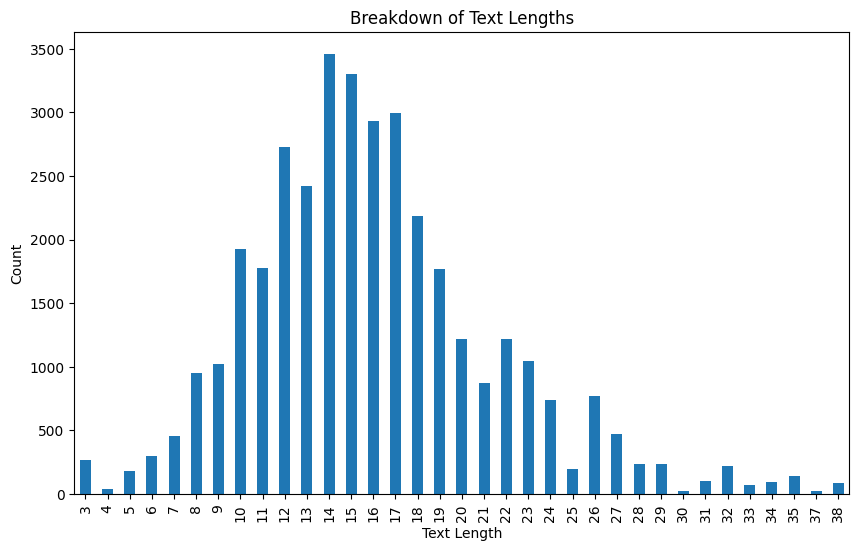

In [121]:
plot_text_length(df, 'anchor')

In [122]:
display_text_examples_by_length(df, 'anchor')

Examples of minimum length text: 3
['ack', 'ack', 'ack', 'ack', 'ack']

Examples of maximum length text: 38
['reflection type liquid crystal display', 'reflection type liquid crystal display', 'reflection type liquid crystal display', 'reflection type liquid crystal display', 'reflection type liquid crystal display']

Examples of medium length text: 15.0
['acid absorption', 'acid absorption', 'acid absorption', 'acid absorption', 'acid absorption']


### Now CONTEXT COLUMN

In [123]:
df.context.describe()

count     36473
unique      106
top         H01
freq       2186
Name: context, dtype: object

In [124]:
df.context.value_counts()

context
H01    2186
H04    2177
G01    1812
A61    1477
F16    1091
       ... 
B03      47
F17      33
B31      24
A62      23
F26      18
Name: count, Length: 106, dtype: int64

In [125]:
unique_and_dups(df.context)

(0.29062594247799745,) 99.709374057522


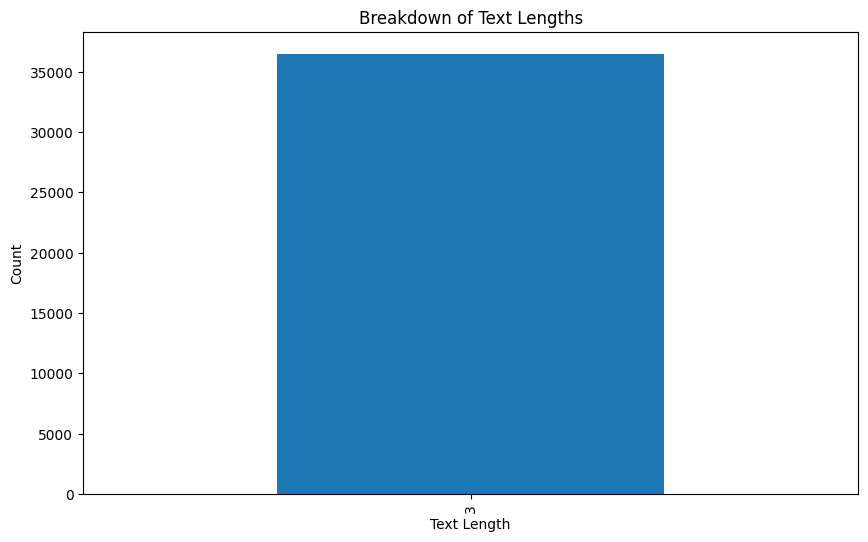

In [126]:
plot_text_length(df, 'context')

In [127]:
display_text_examples_by_length(df, 'context')

Examples of minimum length text: 3
['A47', 'A47', 'A47', 'A47', 'A47']

Examples of maximum length text: 3
['A47', 'A47', 'A47', 'A47', 'A47']

Examples of medium length text: 3.0
['A47', 'A47', 'A47', 'A47', 'A47']


__One additional thing we can do is find the meaning of these context codes by trying to split it__

In [128]:
df['section'] = df.context.str[0]
df.value_counts()

id                anchor                       target                    context  score  text_length  section
000170ce61900fe5  parallel orientation         antiparallel orientation  G06      0.25   3            G          1
a9ff4494f38b489c  produce liquid hydrocarbons  generate oily liquid      C10      0.50   3            C          1
a9f49432dfb21588  vertical chute               channel plane             C21      0.50   3            C          1
a9f581c4c5f89055  axial extension              vertical extension        B05      0.75   3            B          1
a9f82b395d47cdb2  use balance                  function balance          A63      0.50   3            A          1
                                                                                                                ..
5470b88f8c25547d  based propellant             propellant                C06      0.50   3            C          1
54705d7d2a5883ad  upper clamp arm              top clamp arm             A61      0.7

__Observation__

Length is always 3, not many unique values, feels like a funnel/categories

### Finally the Y LABEL (SCORE)

In [129]:
df.score.describe()

count    36473.000000
mean         0.362062
std          0.258335
min          0.000000
25%          0.250000
50%          0.250000
75%          0.500000
max          1.000000
Name: score, dtype: float64

In [130]:
df.score.value_counts()

score
0.50    12300
0.25    11519
0.00     7471
0.75     4029
1.00     1154
Name: count, dtype: int64

<Axes: >

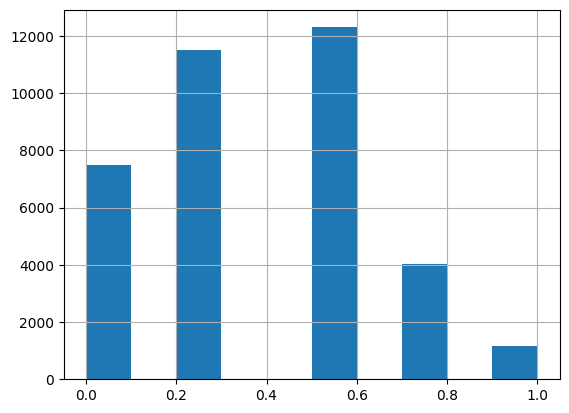

In [131]:
df.score.hist()

In [132]:
# display by lowest correlation score
df[df.score == df.score.min()]

,id,anchor,target,context,score,text_length,section
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.0,3,A
14,9001756895ec8ca1,abatement,pollution certificate,A47,0.0,3,A
15,cc96541d4987b399,abatement,rent abatement,A47,0.0,3,A
18,1222e36d9a94c2a4,abatement,stone abutments,A47,0.0,3,A
19,a8c9e9f37d4d836a,abatement,tax abatement,A47,0.0,3,A
...,...,...,...,...,...,...,...
36447,c7e11e374c52eec4,wood article,article spinner,B44,0.0,3,B
36448,c93eebfb43880214,wood article,article spinning,B44,0.0,3,B
36449,c997d1dc4fbcd02b,wood article,article tracking system,B44,0.0,3,B
36457,1d5bb300f80bc6db,wood article,plastic articles,B44,0.0,3,B


In [133]:
# display by highest correlation score
df[df.score == df.score.max()]

,id,anchor,target,context,score,text_length,section
28,473137168ebf7484,abatement,abating,F24,1.0,3,F
158,621b048d70aa8867,absorbent properties,absorbent characteristics,D01,1.0,3,D
161,bc20a1c961cb073a,absorbent properties,absorption properties,D01,1.0,3,D
311,e955700dffd68624,acid absorption,absorption of acid,B08,1.0,3,B
315,3a09aba546aac675,acid absorption,acid absorption,B08,1.0,3,B
...,...,...,...,...,...,...,...
36398,913141526432f1d6,wiring trough,wiring troughs,F16,1.0,3,F
36435,ee0746f2a8ecef97,wood article,wood articles,B05,1.0,3,B
36440,ecaf479135cf0dfd,wood article,wooden article,B05,1.0,3,B
36464,8ceaa2b5c2d56250,wood article,wood article,B44,1.0,3,B


In [134]:
# display by highest correlation score
df[df.score == df.score.max()]

,id,anchor,target,context,score,text_length,section
28,473137168ebf7484,abatement,abating,F24,1.0,3,F
158,621b048d70aa8867,absorbent properties,absorbent characteristics,D01,1.0,3,D
161,bc20a1c961cb073a,absorbent properties,absorption properties,D01,1.0,3,D
311,e955700dffd68624,acid absorption,absorption of acid,B08,1.0,3,B
315,3a09aba546aac675,acid absorption,acid absorption,B08,1.0,3,B
...,...,...,...,...,...,...,...
36398,913141526432f1d6,wiring trough,wiring troughs,F16,1.0,3,F
36435,ee0746f2a8ecef97,wood article,wood articles,B05,1.0,3,B
36440,ecaf479135cf0dfd,wood article,wooden article,B05,1.0,3,B
36464,8ceaa2b5c2d56250,wood article,wood article,B44,1.0,3,B


In [135]:
# display by most common score
df[df.score == df.score.value_counts().idxmax()]

,id,anchor,target,context,score,text_length,section
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.5,3,A
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.5,3,A
8,0a425937a3e86d10,abatement,minimising sounds,A47,0.5,3,A
10,4c3f2750e7540ab7,abatement,multi pollution abatement device,A47,0.5,3,A
11,84261a11e5d1b68b,abatement,noise reduction,A47,0.5,3,A
...,...,...,...,...,...,...,...
36465,c4ac9d407fb427ab,wood article,wood logs,B44,0.5,3,B
36467,f55e072f78d1fedb,wood article,wood substrate,B44,0.5,3,B
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.5,3,B
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.5,3,B


# How can I turn this into a problem I have solved before

How can I transform the problem a bit so that I can use an angle I know -> how can I turn this into a classification pattern?

**We can transform columns into one single text column that we feed to a NLP model and classify labels**

In [136]:
df['input'] = '#####TARGET: ' + df.target + '; #####ANCHOR: ' + df.anchor + '; #####CAT: ' + df.context
df.input.head()

0    #####TARGET: abatement of pollution; #####ANCHOR: abatement; #####CAT: A47
1            #####TARGET: act of abating; #####ANCHOR: abatement; #####CAT: A47
2           #####TARGET: active catalyst; #####ANCHOR: abatement; #####CAT: A47
3       #####TARGET: eliminating process; #####ANCHOR: abatement; #####CAT: A47
4             #####TARGET: forest region; #####ANCHOR: abatement; #####CAT: A47
Name: input, dtype: object

__So we will have as input one column of text and as target (label) the similarity score__

# Tokenization

In [137]:
from torch.utils.data import DataLoader
import warnings,transformers,logging,torch
from transformers import TrainingArguments,Trainer
from transformers import AutoModelForSequenceClassification,AutoTokenizer

**HuggingFace Transformers tends to be rather enthusiastic about spitting out lots of warnings, so let's quieten it down for our sanity**

In [138]:
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [139]:
model_nm = 'microsoft/deberta-v3-small'

In [140]:
from datasets import Dataset,DatasetDict
ds = Dataset.from_pandas(df)
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'text_length', 'section', 'input'],
    num_rows: 36473
})

In [141]:
tokz = AutoTokenizer.from_pretrained(model_nm)

### Speak your model's language

We'll need to combine the context, anchor, and target together somehow. There's not much research as to the best way to do this, so we may need to iterate a bit. To start with, we'll just combine them all into a single string. The model will need to know where each section starts, so we can use the special separator token to tell it:

In [142]:
sep = tokz.sep_token
sep

'[SEP]'

In [143]:
# clean the old input
del df['input']

In [144]:
df['inputs'] = df.context + sep + df.anchor + sep + df.target

In [145]:
df.inputs.head()

0    A47[SEP]abatement[SEP]abatement of pollution
1            A47[SEP]abatement[SEP]act of abating
2           A47[SEP]abatement[SEP]active catalyst
3       A47[SEP]abatement[SEP]eliminating process
4             A47[SEP]abatement[SEP]forest region
Name: inputs, dtype: object

Generally we'll get best performance if we convert pandas DataFrames into HuggingFace Datasets, so we'll convert them over, and also rename the score column to what Transformers expects for the dependent variable, which is label:

In [146]:
ds = Dataset.from_pandas(df).rename_column('score', 'label')
eval_ds = Dataset.from_pandas(eval_df)

To tokenize the data, we'll create a function (since that's what Dataset.map will need):


In [147]:
def tok_func(x): return tokz(x["inputs"])

In [148]:
tok_func(ds[0])

{'input_ids': [1, 336, 5753, 2, 47284, 2, 47284, 265, 6435, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [149]:
tokz.all_special_tokens

['[CLS]', '[SEP]', '[UNK]', '[PAD]', '[MASK]']

In [150]:
tokz(tokz.sep_token)

{'input_ids': [1, 2, 2], 'token_type_ids': [0, 0, 0], 'attention_mask': [1, 1, 1]}

### We'll use batching to speed it up, and remove the columns we no longer need:

In [151]:
inps = "anchor","target","context"
tok_ds = ds.map(tok_func, batched=True, remove_columns=inps+('inputs','id', 'section'))

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

Looking at the first item of the dataset we should see the same information as when we checked tok_func above

In [152]:
tok_ds[0]

{'label': 0.5,
 'text_length': 3,
 'input_ids': [1, 336, 5753, 2, 47284, 2, 47284, 265, 6435, 2],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

__Now we just have input_ids (the tokenized text to classify) and label the prediction score__

# Create a Validation Set

### First ask yourself as a user of that ML tool, what do I want to do really?

### Then as a user of that ML tool, how will I use this tool? What new data will I add or not add? Imagine what could be the new row in that dataset

### What are the differences between the example data and the real world?

test set constitutes unseen data, so we can take a look to see:
- what is different with our training env
- what are some new edge cases that are worth considering

__The goal here is not to try to cheat and look at the test set to adapt, but also to make the model more generalize for OTHERS potential unseen data, how can we make our training example more random and diverse?__

 You might have context, anchor or targets that you never seen before

In [153]:
df.context.unique()

array(['A47', 'A61', 'A62', 'C01', 'F16', 'F24', 'F28', 'H01', 'H04',
       'B23', 'B41', 'D03', 'E03', 'C08', 'D01', 'D21', 'C07', 'A45',
       'B01', 'B08', 'G04', 'G06', 'B65', 'G16', 'G01', 'A41', 'C23',
       'F23', 'B25', 'A63', 'B28', 'B63', 'F04', 'B60', 'B32', 'C09',
       'C02', 'G03', 'C10', 'B61', 'C21', 'F42', 'A23', 'C11', 'B29',
       'F02', 'B62', 'B64', 'E21', 'B24', 'B22', 'H05', 'B27', 'E04',
       'B21', 'D06', 'C04', 'B05', 'G02', 'H03', 'C06', 'G11', 'C12',
       'E02', 'F15', 'A46', 'B66', 'G07', 'G08', 'C22', 'B44', 'A01',
       'F03', 'C25', 'F22', 'G05', 'G21', 'B07', 'F41', 'E01', 'H02',
       'C13', 'F01', 'F27', 'C14', 'A44', 'B67', 'A24', 'B02', 'E05',
       'D05', 'F25', 'A43', 'A22', 'A21', 'E06', 'F21', 'G10', 'C03',
       'B81', 'F17', 'B03', 'G09', 'D04', 'F26', 'B31'], dtype=object)

In [154]:
eval_df.context.unique()

array(['G02', 'F23', 'B60', 'D06', 'H04', 'C12', 'G11', 'B23', 'C10',
       'F02', 'B01', 'B63', 'B22', 'E04', 'H05', 'C23', 'H02', 'C07',
       'A63', 'G05', 'F16', 'F04', 'A44', 'B61', 'F01', 'B21', 'A61',
       'G01', 'H03'], dtype=object)

In [155]:
# let's check again the col of eval_df
eval_df.columns

Index(['id', 'anchor', 'target', 'context'], dtype='object')

In [156]:
# make a copy of the original training csv and make it look like the eval one
copy_df = pd.read_csv(dataset_path/'train.csv')
copy_df.drop(['score'], axis=1, inplace=True)
copy_df.columns

Index(['id', 'anchor', 'target', 'context'], dtype='object')

In [157]:
def compare_unique_values(df1, df2, column_name):
    """
    Compares unique values in a specified column between two dataframes.

    Parameters:
    - df1: First DataFrame.
    - df2: Second DataFrame.
    - column_name: The name of the column to compare.

    Returns:
    - A tuple containing sets of unique values exclusive to df1 and df2, respectively.
    """
    # Ensure the column exists in both dataframes
    if column_name not in df1.columns or column_name not in df2.columns:
        raise ValueError(f"Column '{column_name}' does not exist in both dataframes.")

    # Convert the column values of both dataframes to sets
    values_df1 = set(df1[column_name])
    values_df2 = set(df2[column_name])

    # Find unique values
    unique_to_df1 = values_df1 - values_df2
    unique_to_df2 = values_df2 - values_df1

    # Print results
    print(f"Values unique to df1's '{column_name}' column:", unique_to_df1)
    print(f"Values unique to df2's '{column_name}' column:", unique_to_df2)

    return len(unique_to_df1), len(unique_to_df2)

compare_unique_values(df, eval_df, 'anchor')

Values unique to df1's 'anchor' column: {'inner closed', 'pen based computer', 'photodefinable', 'boom hydraulic cylinder', 'dna strand', 'rotor stages', 'adjustable multiple', 'plug nozzle', 'sawtooth waves', 'metal phase', 'expandable intraluminal', 'water infiltration', 'extend from groove bottom', 'perform desired action', 'selected box', 'chagas disease', 'prolog', 'alpha gypsum', 'arm roller', 'brush guard', 'vegfr2', 'hybrid system', 'based writing', 'connect to electrode structure', 'register digital converter', 'smooth outer surface', 'fountain head', 'comprise in refinement', 'further additional elements', 'oven batteries', 'oxidizing enzyme', 'her2 targeted', 'component composite coating', 'dissolve in addition', 'select unit', 'lifting finger', 'time domain equalization', 'wake up procedures', 'engage in guide slot', 'obstacle course', 'shift link', 'dimensional location', 'pictorial image', 'vertical chute', 'duplex device', 'new freely flowering', 'sprayed', 'synthetic tr

(699, 0)

### More EDA

### Making the validation set look more like the test set (but our goal is not to train for the test set... REMEMBER REAL WORLD!!!)

__Which column is likely to have value that our model have never seen? Let's read the dataset description again to understand the problem: https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/data__

In [158]:
eval_df

,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04
5,474c874d0c07bd21,dry corn,dry corn starch,C12
6,442c114ed5c4e3c9,tunneling capacitor,capacitor housing,G11
7,b8ae62ea5e1d8bdb,angular contact bearing,contact therapy radiation,B23
8,faaddaf8fcba8a3f,produce liquid hydrocarbons,produce a treated stream,C10
9,ae0262c02566d2ce,diesel fuel tank,diesel fuel tanks,F02


In [159]:
unique_and_dups(df.anchor)

(2.0097058097770955,) 97.9902941902229


Anchor has low variability and lots of dups, meaning it feels like a class

In [160]:
unique_and_dups(df.target)

(80.44306747457023,) 19.556932525429772


Target however has high variability it seems like the thing we are trying to classify

In [161]:
unique_and_dups(df.context)

(0.29062594247799745,) 99.709374057522


Finally context like anchor has low variability, it also feels like a class

So target is the thing we are trying to classify, and we have two column to help us classify this thing: anchor and context

In [162]:
len(df.context.unique())

106

In [163]:
len(df.anchor.unique())

733

### Create a validation split

We will split so that we try to predict for every single anhcors

In [164]:
anchors = df.anchor.unique()
np.random.seed(42)
np.random.shuffle(anchors)
anchors[:5]

array(['time digital signal', 'antiatherosclerotic', 'filled interior',
       'dispersed powder', 'locking formation'], dtype=object)

In [165]:
val_prop = 0.25
val_sz = int(len(anchors)*val_prop)
val_anchors = anchors[:val_sz]

In [166]:
is_val = np.isin(df.anchor, val_anchors)
idxs = np.arange(len(df))
val_idxs = idxs[ is_val]
trn_idxs = idxs[~is_val]
len(val_idxs),len(trn_idxs)

(9116, 27357)

BTW, a lot of people do more complex stuff for creating their validation set, but with a dataset this large there's not much point. As you can see, the mean scores in the two groups are very similar despite just doing a random shuffle:


In [167]:
dds = DatasetDict({"train":tok_ds.select(trn_idxs),
                   "test": tok_ds.select(val_idxs)})

In [168]:
df.iloc[trn_idxs].score.mean(),df.iloc[val_idxs].score.mean()

(0.3623021530138539, 0.3613426941641071)

# Training

### Metric

In [169]:
def corr(eval_pred): return {'pearson': np.corrcoef(*eval_pred)[0][1]}

### Hyperparameters

In [170]:
import platform

# Hardware dependents
bs = 128

# Non hardware dependents
num_labels=1
lr = 8e-5 # find this with find_lr
lr_scheduler_type = 'cosine'
weight_decay = 0.01
epochs = 4
# We'll use fp16 since it's much faster on modern GPUs, and saves some memory. You almost always want this
fp16 = platform.system().lower() != 'darwin'
# We evaluate using double-sized batches, since no gradients are stored so we can do twice as many rows at a time.
per_device_eval_batch_size = bs * 2

In [171]:
from transformers import TrainingArguments    

args = TrainingArguments('outputs',
                        learning_rate=lr,
                        warmup_ratio=0.1,
                        lr_scheduler_type=lr_scheduler_type,
                        fp16=fp16,
                        evaluation_strategy="epoch",
                        per_device_train_batch_size=bs,
                        per_device_eval_batch_size=per_device_eval_batch_size,
                        num_train_epochs=epochs,
                        weight_decay=weight_decay,
                        report_to='none')

In [172]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=num_labels)

In [173]:
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
               tokenizer=tokz, compute_metrics=corr)

In [174]:
trainer.train();

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.026403,0.793910
2,No log,0.026340,0.807178
3,0.032200,0.026405,0.811341
4,0.032200,0.025133,0.813304


# Let's make friends that help us iterate faster

In [175]:
def get_dds(df):
    ds = Dataset.from_pandas(df).rename_column('score', 'label')
    tok_ds = ds.map(tok_func, batched=True, remove_columns=inps+('inputs','id','section'))
    return DatasetDict({"train":tok_ds.select(trn_idxs), "test": tok_ds.select(val_idxs)})

In [176]:
def get_model(): return AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)

def get_trainer(dds, model=None):
    if model is None: model = get_model()
    args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type=lr_scheduler_type, fp16=fp16,
        evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=per_device_eval_batch_size,
        num_train_epochs=epochs, weight_decay=weight_decay, report_to='none')
    return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                   tokenizer=tokz, compute_metrics=corr)

# Let's Experiment!

### A Different Separator?

In [177]:
sep = " [s] "
df['inputs'] = df.context + sep + df.anchor + sep + df.target
dds = get_dds(df)
get_trainer(dds).train()

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.027151,0.806742
2,No log,0.024117,0.815730
3,0.029800,0.024294,0.818609
4,0.029800,0.024139,0.821015


TrainOutput(global_step=856, training_loss=0.02281925054354088, metrics={'train_runtime': 103.1114, 'train_samples_per_second': 1061.26, 'train_steps_per_second': 8.302, 'total_flos': 581591382621300.0, 'train_loss': 0.02281925054354088, 'epoch': 4.0})

Is that useful? If so let's keep that change

### How about smaller applying some transform to the values?

Often changing to lowercase is helpful. Let's see if that helps too:

In [178]:
df['inputs'] = df.inputs.str.lower()
dds = get_dds(df)
get_trainer(dds).train()

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.028847,0.797446
2,No log,0.024107,0.813259
3,0.029800,0.024909,0.817584
4,0.029800,0.024341,0.819439


TrainOutput(global_step=856, training_loss=0.022847458023891272, metrics={'train_runtime': 103.3675, 'train_samples_per_second': 1058.631, 'train_steps_per_second': 8.281, 'total_flos': 581591382621300.0, 'train_loss': 0.022847458023891272, 'epoch': 4.0})

Is that useful?

### Special Tokens?

What if we made the patent section a special token? Then potentially the model might learn to recognize that different sections need to be handled in different ways. To do that, we'll use, e.g. [A] for section A. We'll then add those as special tokens

In [179]:
df['sectok'] = '[' + df.section + ']'
sectoks = list(df.sectok.unique())
tokz.add_special_tokens({'additional_special_tokens': sectoks})

df['inputs'] = df.sectok + sep + df.context + sep + df.anchor.str.lower() + sep + df.target
dds = get_dds(df)

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

Since we've added more tokens, we need to resize the embedding matrix in the model:

In [180]:
model = get_model()
model.resize_token_embeddings(len(tokz))

Embedding(128009, 768)

In [181]:
trainer = get_trainer(dds, model=model)
trainer.train()

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.025648,0.806277
2,No log,0.024142,0.814678
3,0.029400,0.024194,0.818388
4,0.029400,0.024192,0.817797


TrainOutput(global_step=856, training_loss=0.02249815085223902, metrics={'train_runtime': 108.6874, 'train_samples_per_second': 1006.814, 'train_steps_per_second': 7.876, 'total_flos': 694840604004180.0, 'train_loss': 0.02249815085223902, 'epoch': 4.0})

Well... it can get worse

### Keep a single function to apply all the previous inputs

In [182]:
def preprocess_inputs(df):
    sep = " [s] "
    df['inputs'] = df.context + sep + df.anchor + sep + df.target
    df['inputs'] = df.inputs.str.lower()
    df['section'] = df.context.str[0]
    df['sectok'] = '[' + df.section + ']'
    df['inputs'] = df.sectok + sep + df.context + sep + df.anchor.str.lower() + sep + df.target

In [183]:
# it's important to reuse the initial train_df since columns have been modified

def get_tok_ds(df):
    ds = Dataset.from_pandas(df).rename_column('score', 'label')
    return ds.map(tok_func, batched=True, remove_columns=inps+('inputs','id','section'))

df = pd.read_csv(dataset_path/'train.csv')
preprocess_inputs(df)
tok_ds = get_tok_ds(df)

# Cross-Validation

Cross-validation will help us see the impact of minor changes. We will also use folds to group to separate nachors into non overlapping groups and make better balanced datasets

In [184]:
k_folds = 4

In [185]:
from sklearn.model_selection import StratifiedGroupKFold
cv = StratifiedGroupKFold(n_splits=k_folds)

In summary, the code splits the dataset into 4 groups so that anchors are not split accross folds with a balanced distribution of scores

In [186]:
df = df.sample(frac=1, random_state=42)
scores = (df.score*100).astype(int)
folds = list(cv.split(idxs, scores, df.anchor))
folds

[(array([    0,     1,     2, ..., 36469, 36471, 36472]),
  array([    8,    13,    14, ..., 36453, 36464, 36470])),
 (array([    0,     1,     5, ..., 36470, 36471, 36472]),
  array([    2,     3,     4, ..., 36459, 36461, 36462])),
 (array([    1,     2,     3, ..., 36467, 36470, 36472]),
  array([    0,     7,    11, ..., 36468, 36469, 36471])),
 (array([    0,     2,     3, ..., 36469, 36470, 36471]),
  array([    1,     5,     9, ..., 36465, 36467, 36472]))]

In [187]:
def get_fold(folds, fold_num, tok_ds):
    trn,val = folds[fold_num]
    return DatasetDict({"train":tok_ds.select(trn), "test": tok_ds.select(val)})

In [ ]:
ds = Dataset.from_pandas(df).rename_column('score', 'label')
tok_ds = ds.map(tok_func, batched=True, remove_columns=inps+('inputs','id','section'))

In [188]:
dds = get_fold(folds, 0, tok_ds)
dds

DatasetDict({
    train: Dataset({
        features: ['label', 'text_length', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27346
    })
    test: Dataset({
        features: ['label', 'text_length', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9127
    })
})

In [189]:
trainer = get_trainer(dds = get_fold(folds, 0), model=model)
trainer.train()

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.017373,0.884192
2,No log,0.014404,0.892301
3,0.014800,0.013948,0.896640
4,0.014800,0.013907,0.897284


TrainOutput(global_step=856, training_loss=0.01220536872605297, metrics={'train_runtime': 97.4027, 'train_samples_per_second': 1123.008, 'train_steps_per_second': 8.788, 'total_flos': 472405774461360.0, 'train_loss': 0.01220536872605297, 'epoch': 4.0})

### Ensembling

In [190]:
ensemble = []

for i in range(0, k_folds):
    trainer = get_trainer(dds = get_fold(folds, i, tok_ds), model=model)
    trainer.train()
    metrics = [o['eval_pearson'] for o in trainer.state.log_history if 'eval_pearson' in o]
    ensemble.append(metrics[-1])

ensemble

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.018906,0.883282
2,No log,0.015802,0.886787
3,0.006600,0.015039,0.890550
4,0.006600,0.014657,0.891113


Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.005936,0.957614
2,No log,0.005376,0.960000
3,0.009000,0.005319,0.961351
4,0.009000,0.005474,0.961713


Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.006025,0.970031
2,No log,0.004288,0.969540
3,0.006700,0.004023,0.972091
4,0.006700,0.004137,0.971969


Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.003888,0.975695
2,No log,0.003884,0.977476
3,0.005300,0.003351,0.979451
4,0.005300,0.003177,0.979379


[0.8911131926887729,
 0.9617131092299391,
 0.9719689256385684,
 0.9793787742165388]

__Who was the strongest model?__

In [191]:
strongest_model_index = np.argmax(ensemble)
strongest_model_index, np.max(ensemble)

(3, 0.9793787742165388)

# Final Submission

### Train using the full training set

In [192]:
# how to do that after using cross validation?
# I want the improvements that cross validation brought but now on the full training set, how to do that??

In [193]:
trainer = get_trainer(dds = get_fold(folds, strongest_model_index, tok_ds), model=model)
trainer.train()

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.004607,0.967001
2,No log,0.004472,0.970455
3,0.002900,0.004103,0.972637
4,0.002900,0.003955,0.973079


TrainOutput(global_step=856, training_loss=0.002651952903404414, metrics={'train_runtime': 97.4018, 'train_samples_per_second': 1123.347, 'train_steps_per_second': 8.788, 'total_flos': 463299513733320.0, 'train_loss': 0.002651952903404414, 'epoch': 4.0})

### Important - we need to format the input the same way we did during the training

In [194]:
eval_df = pd.read_csv(dataset_path/'test.csv')

preprocess_inputs(eval_df)

eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

### Predict using strongest model

In [195]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds

array([[ 0.39453125],
       [ 0.64355469],
       [ 0.50439453],
       [ 0.25219727],
       [-0.01068115],
       [ 0.50537109],
       [ 0.49487305],
       [-0.01876831],
       [ 0.24279785],
       [ 1.04589844],
       [ 0.24523926],
       [ 0.24389648],
       [ 0.76904297],
       [ 0.80029297],
       [ 0.75585938],
       [ 0.23461914],
       [ 0.24511719],
       [-0.01795959],
       [ 0.50244141],
       [ 0.50048828],
       [ 0.5       ],
       [ 0.24841309],
       [ 0.24243164],
       [ 0.24719238],
       [ 0.51123047],
       [-0.01026917],
       [-0.01029968],
       [-0.0111618 ],
       [-0.00917816],
       [ 0.72998047],
       [ 0.23352051],
       [-0.01141357],
       [ 0.78857422],
       [ 0.68505859],
       [ 0.24768066],
       [ 0.2467041 ]])

### Cleaning

In [196]:
preds = np.clip(preds, 0, 1)
preds

array([[0.39453125],
       [0.64355469],
       [0.50439453],
       [0.25219727],
       [0.        ],
       [0.50537109],
       [0.49487305],
       [0.        ],
       [0.24279785],
       [1.        ],
       [0.24523926],
       [0.24389648],
       [0.76904297],
       [0.80029297],
       [0.75585938],
       [0.23461914],
       [0.24511719],
       [0.        ],
       [0.50244141],
       [0.50048828],
       [0.5       ],
       [0.24841309],
       [0.24243164],
       [0.24719238],
       [0.51123047],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.72998047],
       [0.23352051],
       [0.        ],
       [0.78857422],
       [0.68505859],
       [0.24768066],
       [0.2467041 ]])

In [197]:
import datasets

submission = datasets.Dataset.from_dict({
    'id': eval_ds['id'],
    'score': preds.flatten()
})

submission.to_csv('submission.csv', index=False)
submission

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['id', 'score'],
    num_rows: 36
})